In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

import torch
from torch import nn
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import radius_graph

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
with h5py.File('data/train_xyze_1e4.h5', 'r') as f:
    # Access the dataset
    label_events = f['data']
    data = []
    for i, event in enumerate(label_events):
        pts = f['data'][i].reshape(-1,4)
        data.append(pts)
    
#     n_signal_events = 0
    
#     n_michel_voxels = np.zeros(len(label_events))

#     # Iterate and print each event (which is a variable-length array)
#     for i, event in enumerate(label_events):
#         print(f"Event {i}: {event} (length = {len(event)})")
#         n_signal_events += np.any(event == 2)
#         n_michel_voxels[i] = np.sum(event == 2)

# # Corrected the misplaced parenthesis in the print statement
# print("Fraction of events with Michel electrons:", (n_signal_events / len(label_events)) * 100, "%")

In [4]:
# Open the labels file
with h5py.File('data/train_label_1e4.h5', 'r') as f:
    # Access the dataset
    label_events = f['labels']
    
    labels = []

    for i, event in enumerate(label_events):
        labels.append(event)

In [5]:
# Define the training truth labels
# 2 is the label for Michel electrons
truth = [(event_labels == 2).astype(np.int32) for event_labels in labels]
# val_truth = torch.tensor([x for x_event in val_truth for x in x_event]).to(device)

In [6]:
# Input: sparse tensor with coordinates and features
# coordinates: Nx4 tensor (batch_idx, x, y, z)
# features: Nx1 tensor (voxel values)
# Iterate over the events and create sparse tensors
# Example input data

train_data = []
val_data = []
test_data = []

# Iterate over all the events and create sparse tensors that are then merged
# For each input_coords, add another column for the batch index, which is just the index of the event
for i, (event_coords, input_labels) in enumerate(zip(tqdm(data), truth)):
    if i < 5000:
        continue
    
    # For now, only use parts of the dataset to save memory
    # if i >= 5000:
    #     break
    
    # Use the first three columns as coordinates
    input_coords = torch.tensor(event_coords[:, :3], dtype=torch.int32)  
    # input_coords = torch.cat((torch.full((input_coords.shape[0], 1), i, dtype=torch.int32), input_coords), dim=1)  # Add batch index
    # Use the fourth column as features
    input_features = torch.tensor(event_coords[:, 3], dtype=torch.float32).unsqueeze(1)
    
    edge_index = radius_graph(input_coords, r=3.0, loop=False)
    
    event_data = Data(
        x=input_features,
        edge_index=edge_index,
        y=torch.tensor(input_labels, dtype=torch.float32),
        pos=input_coords,
    )

    # if i < 500:
    #     val_data.append(event_data)
    #     continue
    # if i < 1000:
    #     test_data.append(event_data)
    #     continue

    train_data.append(event_data)

100%|██████████| 10000/10000 [01:54<00:00, 87.26it/s]  


In [7]:
with open('data/gnn_train_data_1.pkl', 'wb') as f:
    pickle.dump(train_data, f)

In [8]:
with open('data/gnn_val_data.pkl', 'wb') as f:
    pickle.dump(val_data, f)

In [9]:
with open('data/gnn_test_data.pkl', 'wb') as f:
    pickle.dump(test_data, f)

In [15]:
with open('data/gnn_train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)
# with open('data/gnn_train_data_1.pkl', 'rb') as f:
#     train_data1 = pickle.load(f)
with open('data/gnn_val_data.pkl', 'rb') as f:
    val_data = pickle.load(f)
# with open('data/gnn_test_data.pkl', 'rb') as f:
#     test_data = pickle.load(f)

len(train_data), len(val_data)#, len(test_data)

(4000, 500)

In [16]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [ ]:
train_n_nodes = sum(len(d.x) for d in train_loader)
val_n_nodes = sum(len(d.x) for d in val_loader)
print(f"Train nodes: {train_n_nodes}, Val nodes: {val_n_nodes}")

In [18]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
# Initialize model
model = GNN(input_dim=1, hidden_dim=4, output_dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

train_loss_list = []
val_loss_list = []

# Training loop with validation
best_val_f1 = 0.0
for epoch in range(5):
    # Training
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        out = model(batch)
        weight = batch.y.unsqueeze(1) + 0.1
        loss = F.binary_cross_entropy_with_logits(out, batch.y.unsqueeze(1), reduction="none")
        loss = (loss * weight).sum()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Divide by the total number of nodes in all batches
    train_loss /= train_n_nodes
    
    train_loss_list.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    preds = []

    with torch.no_grad():
        for batch in val_loader:
            weight = batch.y.unsqueeze(1) + 0.1
            out = model(batch)
            val_loss = F.binary_cross_entropy_with_logits(out, batch.y.unsqueeze(1), reduction="none")
            val_loss = (loss * weight).sum().item()
            preds.append(out)

    val_loss /= val_n_nodes
    val_loss_list.append(val_loss)
    
    val_f1 = f1_score(
        torch.cat([batch.y for batch in val_loader]).cpu().numpy(),
        torch.cat([F.sigmoid(batch) > 0.5 for batch in preds]).squeeze().cpu().numpy(),
        # average='macro'
    )

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pt")
    
    # Save best model
    # if val_f1 > best_val_f1:
    #     best_val_f1 = val_f1
    #     torch.save(model.state_dict(), "best_model.pt")

100%|██████████| 125/125 [00:28<00:00,  4.35it/s]


Epoch 1, Train Loss: 0.0604, Val Loss: 0.0000, Val F1: 0.0000


100%|██████████| 125/125 [00:29<00:00,  4.31it/s]


Epoch 2, Train Loss: 0.0506, Val Loss: 0.0000, Val F1: 0.0000


100%|██████████| 125/125 [00:29<00:00,  4.24it/s]


Epoch 3, Train Loss: 0.0501, Val Loss: 0.0000, Val F1: 0.0000


 27%|██▋       | 34/125 [00:08<00:22,  4.13it/s]


In [23]:
F.binary_cross_entropy_with_logits(out, batch.y.unsqueeze(1), reduction="none")

tensor([[0.2330],
        [0.2416],
        [0.2407],
        ...,
        [0.2259],
        [0.2063],
        [0.2208]])

(0.0, 0.1)

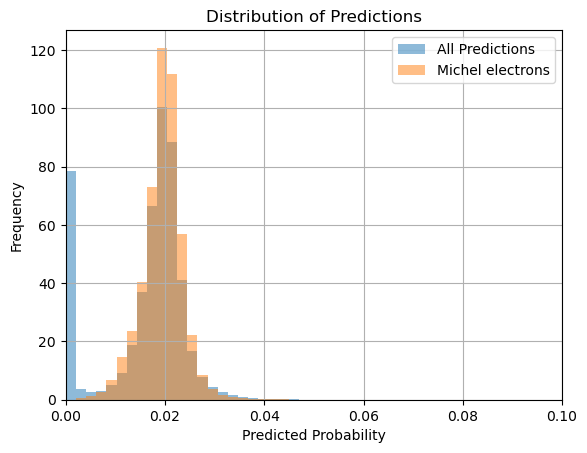

In [11]:
# plot the distribution of predictions
plt.hist(torch.cat([F.sigmoid(batch) for batch in preds]).squeeze().cpu().numpy(), density=True, bins=np.linspace(0, 0.1, 50), alpha=0.5, label="All Predictions")
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions')
# plot the distribution of predictions for only nodes with label 1
plt.hist(torch.cat([F.sigmoid(batch)[batch2.y == 1] for batch2, batch in zip(val_loader, preds)]).squeeze().cpu().numpy(), density=True, bins=np.linspace(0, 0.1, 50), alpha=0.5, label="Michel electrons")
plt.legend()
plt.grid()
plt.xlim(0, 0.1)

In [12]:
preds_flat = torch.cat([F.sigmoid(batch) for batch in preds])

In [13]:
# Plot the F1 score as a function of the cut value
cut_values = np.linspace(0, 0.1, 10)
f1_scores = []
for cut in cut_values:
    preds_cut = preds_flat > cut
    f1 = f1_score(
        torch.cat([batch.y for batch in val_loader]).cpu().numpy(),
        preds_cut.squeeze().cpu().numpy(),
        # average='macro'
    )
    f1_scores.append(f1)

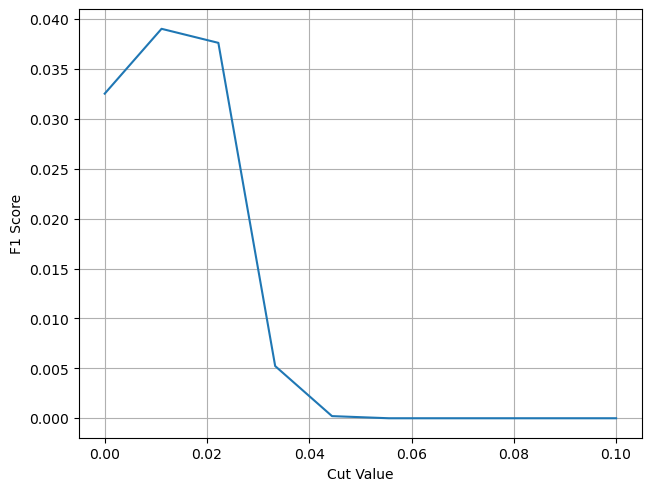

In [14]:
fig, ax = plt.subplots(layout="constrained")
ax.plot(cut_values, f1_scores, label='F1 Score')
ax.set_xlabel('Cut Value')
ax.set_ylabel('F1 Score')
ax.grid()

In [5]:
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
val_loader2 = DataLoader(val_data, batch_size=64, shuffle=False)

In [9]:
model = GNN(input_dim=1, hidden_dim=4, output_dim=1)
model.load_state_dict(torch.load("model_epoch_5.pt"))

<All keys matched successfully>

In [10]:
# Load the model and calculate the predictions for the two loaders
model.eval()
with torch.no_grad():
    preds1 = []
    for batch in val_loader:
        out = model(batch)
        preds1.append(F.sigmoid(out))

    preds2 = []
    for batch in val_loader2:
        out = model(batch)
        preds2.append(F.sigmoid(out))

In [12]:
torch.testing.assert_close(torch.cat(preds1), torch.cat(preds2), rtol=1e-5, atol=1e-5)
print("Predictions from both loaders are close enough.")

Predictions from both loaders are close enough.
